In [110]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import scienceplots
plt.style.use(['science','notebook', 'grid'])
# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')

## 1. Reading Data and Calibration Files

In [111]:
# Calibration Files as in 4:36 pm

ground = pd.read_csv('Data/ground1.csv')
sky = pd.read_csv('Data/sky1.csv')

freq = np.array(ground['Frequency (MHz)'])
# same for all the data

In [112]:
k = 7
# longitude counter 

In [113]:
GalLong = np.array([15,25,35,45,55,65,75,85,115,135]) # galactic longitudes

filepath = 'Data/'+str(GalLong[k])+'.csv'
# milky way reading # SOURCE
mw = pd.read_csv(filepath)

## 2. Plot Power v/s Frequency for a given longitude.


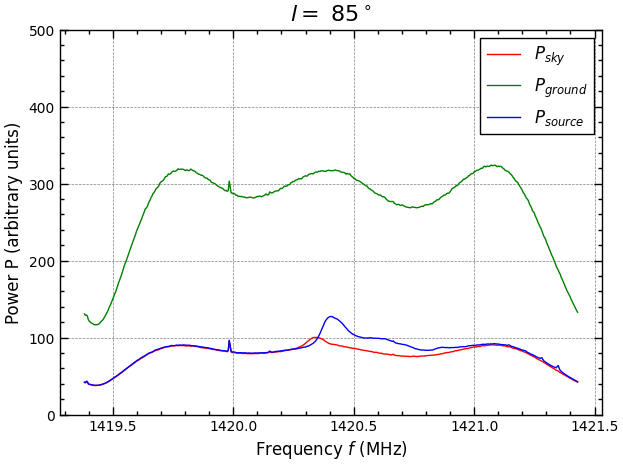

In [114]:
plt.figure(figsize=(7, 5))

#PLOT HERE
plt.plot(freq, np.array(sky['Power (arbitrary units)']), label=r'$P_{sky}$', lw=1, c='r')
plt.plot(freq, np.array(ground['Power (arbitrary units)']), label=r'$P_{ground}$', lw=1, c='g')
plt.plot(freq, np.array(mw['Power (arbitrary units)']), label=r'$P_{source}$', lw=1, c='b')

plt.ylabel('Power P (arbitrary units)', fontsize=12)
plt.xlabel('Frequency $f$ (MHz)', fontsize=12)
plt.ylim((0, 500))

# Change font size of tick labels
plt.tick_params(axis='both', which='major', labelsize=10)  # For major ticks
plt.tick_params(axis='both', which='minor', labelsize=6)  # For minor ticks (if enabled)
plt.title(f'$l = $ {GalLong[k]}$^\circ$')
plt.legend(loc='upper right', fancybox = False, edgecolor = 'k',fontsize=12)


#save this 
filesave = 'Results/' + str(GalLong[k]) + 'Power.png'
plt.savefig(filesave,dpi=500,facecolor='w')


plt.show()

## 3. Convert Power axis to Brightness Temperature ($𝑇_𝑏$)

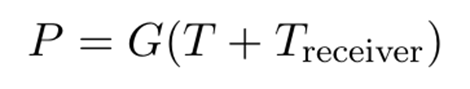

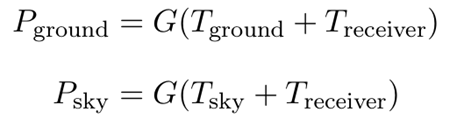


In [115]:
Tsky = 5 #K
Tg = 300

# receiver temperature
PgPsky = np.array(ground['Power (arbitrary units)'])/np.array(sky['Power (arbitrary units)'])
Tr = (Tsky*PgPsky - Tg)/(1-PgPsky)

### 2.2 Calibrate $T_{receiver}$ by removing the H1 artefact.


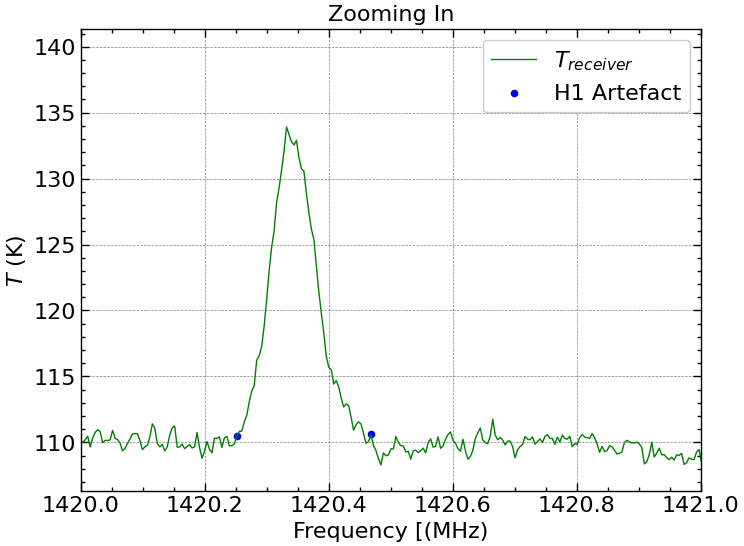

In [116]:
## ZOOM TO SEE THE portion
plt.title('Zooming In')
plt.xlabel('Frequency [(MHz)')
plt.ylabel(r'$T$ (K)')
plt.plot(freq, Tr, label=r'$T_{receiver}$',lw=1,c='g')

#change this to control the zooming
plt.xlim(1420, 1421)

# Define the peak region (manually)
start = 1420.25
end = 1420.47


# Mask out the peak region for fitting
peak_mask = (freq >= start) & (freq <= end)



#Plot the end points and check

freq_fit = [freq[peak_mask][0], freq[peak_mask][-1]]
Tr_fit = [Tr[peak_mask][0], Tr[peak_mask][-1]]
plt.scatter(freq_fit,Tr_fit,c='b',label = 'H1 Artefact',s=20)

plt.legend()

plt.show()

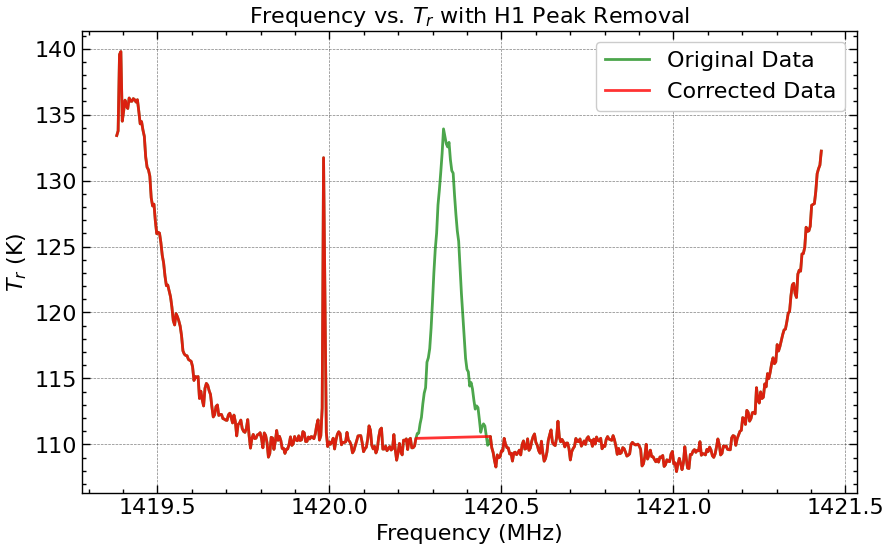

In [117]:
# Define a linear function
def linear(x, a, b):
    return a*x + b

# Perform the linear fit
params, _ = curve_fit(linear, freq_fit, Tr_fit)
a, b = params

# Generate the baseline
baseline = linear(freq[peak_mask], a, b)

# Replace the peak region with the baseline
Tfit = Tr.copy()
Tfit[peak_mask] = baseline


# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(freq, Tr, c= 'g',label='Original Data', alpha=0.7)
plt.plot(freq, Tfit, label='Corrected Data', color='red', alpha=0.8)
plt.legend()
plt.xlabel('Frequency (MHz)')
plt.ylabel('$T_r$ (K)')
plt.title('Frequency vs. $T_r$ with H1 Peak Removal')

plt.show()

## 3. Calculate $T_a$, shift baseline to get $T_s$ (Brightness Temp of the source)

In [118]:
b = np.array(ground['Power (arbitrary units)'])/np.array(mw['Power (arbitrary units)'])
Ta = (Tg + Tfit)/b - Tfit

# subtract the continuum background to get the desired H1
TBright =  Ta - np.min(Ta)

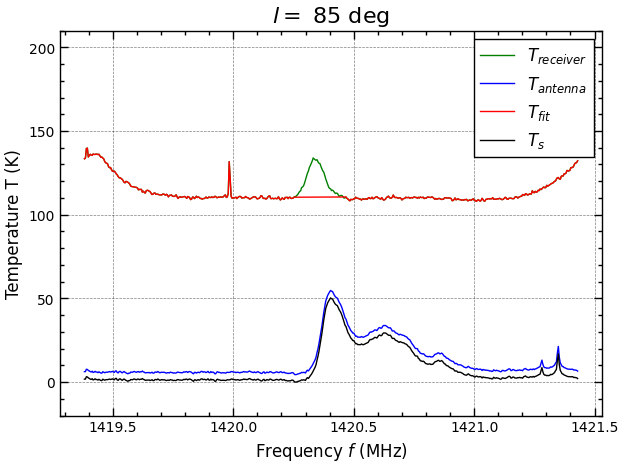

In [119]:
plt.figure(figsize=(7, 5))

plt.plot(freq, Tr, label=r'$T_{receiver}$', lw=1, c='g')
plt.plot(freq, Ta, label=r'$T_{antenna}$', lw=1, c='b')
plt.plot(freq, Tfit, label=r'$T_{fit}$', lw=1, c='r')
plt.plot(freq, TBright, label=r'$T_{s}$', lw=1, c='k')

plt.ylabel('Temperature T (K)', fontsize = 12)
plt.xlabel('Frequency $f$ (MHz)', fontsize = 12)
plt.title(f'$l = $ {GalLong[k]} $\deg$')
# Change font size of tick labels
plt.tick_params(axis='both', which='major', labelsize=10)  # For major ticks
plt.tick_params(axis='both', which='minor', labelsize=6)  # For minor ticks (if enabled)
plt.ylim((-20,210))
plt.legend(loc='upper right', fancybox = False, edgecolor = 'k',fontsize = 12)


filesave = 'Results/' + str(GalLong[k]) + 'Temp.png'
plt.savefig(filesave,dpi=500,facecolor='w')

plt.show()

## 4. Change frequency to velocity and LSR Correction

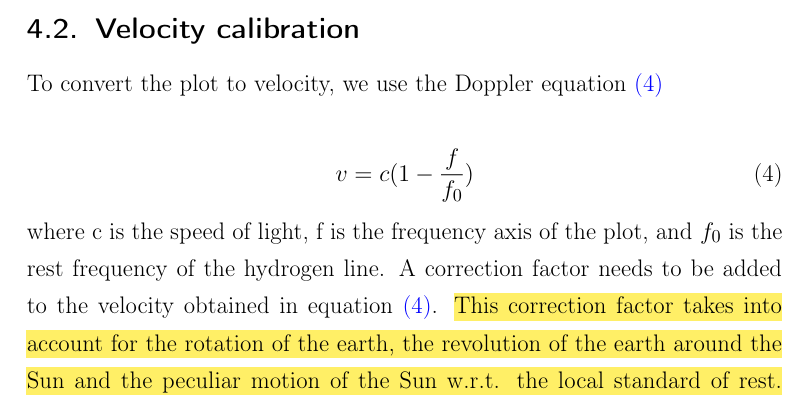

Local Standard of Rest Correction -- to make results independent of our location on earth / solar system

In [120]:
v_lsr = np.array([-11.1622,
                  -10.6882,
                  -9.5282,
                  -8.0994,
                  -6.48644,
                  -4.93495,
                  -2.94176,
                  -1.174827,
                  4.85387,
                  8.03818])

f0 = 1420.4057 #MHz
c = 299792.458 #km/s
v = c*(1-freq/f0)
v_corr = v - v_lsr[k]

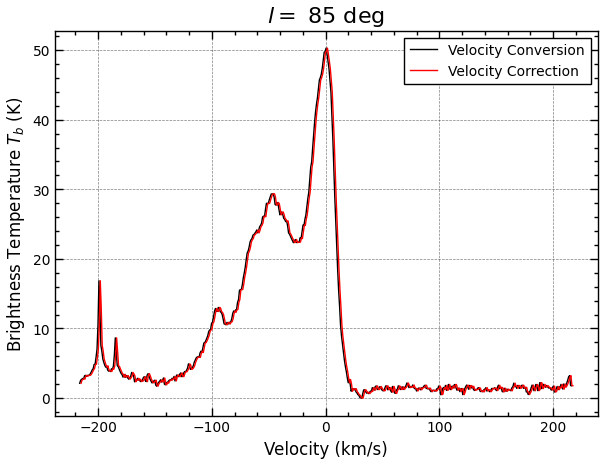

In [121]:
plt.figure(figsize=(7, 5))

plt.plot(v, TBright ,lw=1 ,c='k' ,label = 'Velocity Conversion')
plt.plot(v_corr, TBright, lw=1, c='r', label = 'Velocity Correction')

plt.ylabel(r'Brightness Temperature $T_b$ (K)',fontsize = 12)
plt.xlabel(r'Velocity (km/s)',fontsize = 12)
plt.title(f'$l = $ {GalLong[k]} $\deg$')

# Change font size of tick labels
plt.tick_params(axis='both', which='major', labelsize=10)  # For major ticks
plt.tick_params(axis='both', which='minor', labelsize=6)  # For minor ticks (if enabled)
plt.legend(loc='best', fancybox = False, edgecolor = 'k',fontsize = 10)

#save
filesave = 'Results/' + str(GalLong[k]) + 'VelCorr.png'
plt.savefig(filesave,dpi=500,facecolor='w')


plt.show()



In [122]:
# LSR Correction Code. Copyright  Mhaske et al.
# https://doi.org/10.1119/5.0065381

# from __future__ import print_function, division
# from PyAstronomy import pyasl
# import math
# import datetime
#  # Coordinates of telescope
# longitude = 73.8253
# latitude = 18.5593
# altitude = 554
#  # Coordinates of source (RA2000, DEC2000) RA_hr RA_min RA_sec
# # DEC_deg DEC_min DEC_sec. Note DEC must be signed + or-.
# hd1 = "03 07 07.85 +58 19 30.20" #put the RA DEC coordimates of the longitude in galactic plane
# obs_ra_2000, obs_dec_2000 = pyasl.coordsSexaToDeg(hd1)
#  # Time of observation converted to Julian Date
# dt = datetime.datetime(2024, 12, 19, 17, 35, 00) # change this for each source
# jd = pyasl.jdcnv(dt)
#  # Calculate barycentric correction (debug=True show
#  # various intermediate results)
# corr, hjd = pyasl.helcorr(longitude, latitude, altitude,
# obs_ra_2000, obs_dec_2000, jd, debug=True)

# #print("Barycentric correction [km/s]: ", corr)
#  #print("Heliocentric Julian day: ", hjd)
#  # Calculate LSR correction
# v_sun = 20.5 # peculiar velocity (km/s) of sun w.r.t. LSR
# #  (The Solar Apex. Nature 162, 920 (1948).  https://doi.org/10.1038/162920a0)
#  # solar apex
# sun_ra = math.radians(270.2)
# sun_dec = math.radians(28.7)
# obs_dec = math.radians(obs_dec_2000)
# obs_ra = math.radians(obs_ra_2000)
# a = math.cos(sun_dec) * math.cos(obs_dec)
# b = (math.cos(sun_ra) * math.cos(obs_ra)) + (math.sin(sun_ra)
#  * math.sin(obs_ra))
# c = math.sin(sun_dec) * math.sin(obs_dec)
# v_rs = v_sun * ((a * b) + c)
# v_lsr = corr + v_rs
# print("LSR correction [km/s]: ",-v_lsr)
# print("Positive value means receding (redshift) source,negative value means approaching (blueshift) source")

## 5. Saving Data and proceed to Multipeak fitting

In [123]:
# Combine the two arrays into a single 2D array
data = np.column_stack((v_corr, TBright))

# Specify the file name
output_file = 'MultipeakFit/TempVel/dat' + str(GalLong[k]) + ".csv"

# Customized header
header = "VLSR,Tbright"

# Save the data as a .csv file
np.savetxt(output_file, data, delimiter=',', header=header, comments='', fmt='%.6f')

print(f"Data saved to {output_file}")

Data saved to MultipeakFit/TempVel/dat85.csv
